In [3]:
# Cell 1: Mount Google Drive and check file existence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
base_path = "/content/drive/MyDrive/AgriYield_Data/"

crop_path = os.path.join(base_path, "Crop_recommendation.csv")
fao_path  = os.path.join(base_path, "FAOSTAT_data_en_11-19-2025.csv")

print("Crop path:", crop_path)
print("FAO path:", fao_path)
print("\nExists?")
print("  Crop_recommendation.csv :", os.path.exists(crop_path))
print("  FAOSTAT_data_en_11-19-2025.csv :", os.path.exists(fao_path))

# If files are not found, show listing of the folder to help debug
if not (os.path.exists(crop_path) and os.path.exists(fao_path)):
    print("\nFiles in folder", base_path)
    for f in os.listdir(base_path):
        print(" ", f)

Crop path: /content/drive/MyDrive/AgriYield_Data/Crop_recommendation.csv
FAO path: /content/drive/MyDrive/AgriYield_Data/FAOSTAT_data_en_11-19-2025.csv

Exists?
  Crop_recommendation.csv : True
  FAOSTAT_data_en_11-19-2025.csv : True


In [5]:
# Cell 2: Load CSVs and display basic info
import pandas as pd
from IPython.display import display

crop = pd.read_csv(crop_path)
fao  = pd.read_csv(fao_path)

print("Crop shape:", crop.shape)
print("Crop columns:", crop.columns.tolist())
print("\nFAO shape:", fao.shape)
print("FAO columns:", fao.columns.tolist())

print("\n--- Crop head ---")
display(crop.head())

print("\n--- FAO head ---")
display(fao.head())


Crop shape: (2200, 8)
Crop columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

FAO shape: (5940, 15)
FAO columns: ['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code', 'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag', 'Flag Description', 'Note']

--- Crop head ---


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice



--- FAO head ---


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN
1,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,kg/ha,484.0,A,Official figure,NaN
2,QCL,Crops and livestock products,356,India,5510,Production,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,t,166692.0,A,Official figure,NaN
3,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,ha,569271.0,A,Official figure,NaN
4,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,kg/ha,430.3,A,Official figure,NaN


In [6]:
# Cell 3: Prepare crop dataset (create crop_clean)
import numpy as np

# If crop dataset uses 'label' column for crop names, rename to Crop
if "label" in crop.columns and "Crop" not in crop.columns:
    crop = crop.rename(columns={"label": "Crop"})

# Create standardized crop_clean column for merging
crop['crop_clean'] = crop['Crop'].astype(str).str.lower().str.strip()

print("Unique crops in crop_recommendation (sample):")
display(sorted(list(set(crop['crop_clean']))[:50]))
print("\nCrop dataset preview:")
display(crop.head())


Unique crops in crop_recommendation (sample):


['apple',
 'banana',
 'blackgram',
 'chickpea',
 'coconut',
 'coffee',
 'cotton',
 'grapes',
 'jute',
 'kidneybeans',
 'lentil',
 'maize',
 'mango',
 'mothbeans',
 'mungbean',
 'muskmelon',
 'orange',
 'papaya',
 'pigeonpeas',
 'pomegranate',
 'rice',
 'watermelon']


Crop dataset preview:


,N,P,K,temperature,humidity,ph,rainfall,Crop,crop_clean
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,rice


In [7]:
# Cell 4: Clean FAO 'Item' column, lower, remove parentheses, split by comma
import re

fao_proc = fao.copy()

# If FAO uses "Item" column name otherwise try "Crop" or "Item " variations
possible_item_cols = [c for c in fao_proc.columns if c.lower().strip() in ("item", "crop", "item ")]
item_col = None
for c in possible_item_cols:
    if "item" in c.lower() or "crop" in c.lower():
        item_col = c
        break

if item_col is None:
    raise KeyError("Could not find 'Item' or 'Crop' column in FAO. Columns: " + str(fao_proc.columns.tolist()))

print("Using FAO column for crop names:", item_col)

def preprocess_item(x):
    s = str(x).lower()
    # remove parentheses content
    s = re.sub(r"\(.*?\)", "", s)
    return s

fao_proc['Item_clean_raw'] = fao_proc[item_col].apply(preprocess_item)
print("\nSample cleaned Item values (not exploded):")
display(fao_proc[['Item_clean_raw']].head(10))


Using FAO column for crop names: Item

Sample cleaned Item values (not exploded):


,Item_clean_raw
0,"anise, badian, coriander, cumin, caraway, fenn..."
1,"anise, badian, coriander, cumin, caraway, fenn..."
2,"anise, badian, coriander, cumin, caraway, fenn..."
3,"anise, badian, coriander, cumin, caraway, fenn..."
4,"anise, badian, coriander, cumin, caraway, fenn..."
5,"anise, badian, coriander, cumin, caraway, fenn..."
6,"anise, badian, coriander, cumin, caraway, fenn..."
7,"anise, badian, coriander, cumin, caraway, fenn..."
8,"anise, badian, coriander, cumin, caraway, fenn..."
9,"anise, badian, coriander, cumin, caraway, fenn..."


In [8]:
# Cell 5: Explode the cleaned 'Item' by commas into multiple rows (keep fragments)
fao_proc['Item_list'] = fao_proc['Item_clean_raw'].str.split(',')

# Explode list into rows
fao_exp = fao_proc.explode('Item_list').copy()

# Clean exploded fragments: strip and remove non-letters (keep spaces)
fao_exp['crop_clean'] = (
    fao_exp['Item_list']
    .astype(str)
    .str.strip()
    .str.replace(r"[^a-zA-Z ]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

print("Exploded FAO shape (before filtering):", fao_exp.shape)
print("\nSample exploded rows (first 20):")
display(fao_exp[['Item_clean_raw','Item_list','crop_clean']].head(20))

print("\nUnique exploded crop fragments (sample 50):")
display(sorted(list(set(fao_exp['crop_clean']))[:50]))


Exploded FAO shape (before filtering): (9088, 18)

Sample exploded rows (first 20):


,Item_clean_raw,Item_list,crop_clean
0,"anise, badian, coriander, cumin, caraway, fenn...",anise,anise
0,"anise, badian, coriander, cumin, caraway, fenn...",badian,badian
0,"anise, badian, coriander, cumin, caraway, fenn...",coriander,coriander
0,"anise, badian, coriander, cumin, caraway, fenn...",cumin,cumin
0,"anise, badian, coriander, cumin, caraway, fenn...",caraway,caraway
0,"anise, badian, coriander, cumin, caraway, fenn...",fennel and juniper berries,fennel and juniper berries
0,"anise, badian, coriander, cumin, caraway, fenn...",raw,raw
1,"anise, badian, coriander, cumin, caraway, fenn...",anise,anise
1,"anise, badian, coriander, cumin, caraway, fenn...",badian,badian
1,"anise, badian, coriander, cumin, caraway, fenn...",coriander,coriander



Unique exploded crop fragments (sample 50):


['anise',
 'apricots',
 'badian',
 'bananas',
 'barley',
 'beans',
 'cabbages',
 'cantaloupes and other melons',
 'caraway',
 'cardamoms',
 'carrots and turnips',
 'cassava',
 'castor oil seeds',
 'chick peas',
 'clementines',
 'coffee',
 'cucumbers and gherkins',
 'dry',
 'figs',
 'fresh',
 'fresh nec',
 'groundnuts',
 'guavas and mangosteens',
 'lettuce and chicory',
 'linseed',
 'mushrooms and truffles',
 'natural rubber in primary forms',
 'nec',
 'okra',
 'oranges',
 'other berries and fruits of the genus vaccinium nec',
 'other oil seeds',
 'other stimulant',
 'other vegetables',
 'papayas',
 'pigeon peas',
 'pomelos and grapefruits',
 'poppy seed',
 'raw',
 'rice',
 'sesame seed',
 'soya beans',
 'spice and aromatic crops',
 'sunflower seed',
 'sweet potatoes',
 'tangerines',
 'tomatoes',
 'true hemp',
 'unginned',
 'watermelons']

In [9]:
# Cell 6: Keep only exploded fragments that match crop dataset's crop_clean
valid_crops = set(crop['crop_clean'])
print("Number of valid crops in crop dataset:", len(valid_crops))

# Filter rows where exploded crop_clean is in valid_crops and non-empty
fao_exp_valid = fao_exp[fao_exp['crop_clean'].isin(valid_crops)].copy()
fao_exp_valid = fao_exp_valid[fao_exp_valid['crop_clean'].notna() & (fao_exp_valid['crop_clean'] != "")]

print("Exploded FAO shape AFTER filtering to valid crops:", fao_exp_valid.shape)
print("\nValid crop fragments kept (unique):")
display(sorted(fao_exp_valid['crop_clean'].unique()))

print("\nPreview of filtered exploded FAO (first 20):")
display(fao_exp_valid.head(20))


Number of valid crops in crop dataset: 22
Exploded FAO shape AFTER filtering to valid crops: (360, 18)

Valid crop fragments kept (unique):


['coffee', 'grapes', 'jute', 'maize', 'rice']


Preview of filtered exploded FAO (first 20):


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note,Item_clean_raw,Item_list,crop_clean
1434,QCL,Crops and livestock products,356,India,5312,Area harvested,1610.0,"Coffee, green",2000,2000,ha,308433.0,A,Official figure,NaN,"coffee, green",coffee,coffee
1435,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2000,2000,kg/ha,946.7,A,Official figure,NaN,"coffee, green",coffee,coffee
1436,QCL,Crops and livestock products,356,India,5510,Production,1610.0,"Coffee, green",2000,2000,t,292000.0,A,Official figure,NaN,"coffee, green",coffee,coffee
1437,QCL,Crops and livestock products,356,India,5312,Area harvested,1610.0,"Coffee, green",2001,2001,ha,313934.0,A,Official figure,NaN,"coffee, green",coffee,coffee
1438,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2001,2001,kg/ha,958.8,A,Official figure,NaN,"coffee, green",coffee,coffee
1439,QCL,Crops and livestock products,356,India,5510,Production,1610.0,"Coffee, green",2001,2001,t,301000.0,A,Official figure,NaN,"coffee, green",coffee,coffee
1440,QCL,Crops and livestock products,356,India,5312,Area harvested,1610.0,"Coffee, green",2002,2002,ha,320737.0,A,Official figure,NaN,"coffee, green",coffee,coffee
1441,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2002,2002,kg/ha,938.5,A,Official figure,NaN,"coffee, green",coffee,coffee
1442,QCL,Crops and livestock products,356,India,5510,Production,1610.0,"Coffee, green",2002,2002,t,301000.0,A,Official figure,NaN,"coffee, green",coffee,coffee
1443,QCL,Crops and livestock products,356,India,5312,Area harvested,1610.0,"Coffee, green",2003,2003,ha,320615.0,A,Official figure,NaN,"coffee, green",coffee,coffee


In [10]:
# Cell 7: Keep only Element == 'Yield' (if Element column exists)
elem_col = None
for c in fao_exp_valid.columns:
    if c.lower() == "element":
        elem_col = c
        break

if elem_col:
    print("FAO Element column found:", elem_col)
    print("Element value counts (sample):")
    display(fao_exp_valid[elem_col].value_counts().head(20))
    # filter
    fao_yield_exploded = fao_exp_valid[fao_exp_valid[elem_col] == "Yield"].copy()
else:
    # If no Element column, try to find 'Element' with capitalization differences
    print("No exact 'Element' column found. Trying case-insensitive search...")
    possible = [c for c in fao_exp_valid.columns if c.lower() == 'element']
    if possible:
        elem_col = possible[0]
        fao_yield_exploded = fao_exp_valid[fao_exp_valid[elem_col] == "Yield"].copy()
    else:
        # If FAO doesn't have Element, keep all (warn)
        print("WARNING: No Element column detected — keeping all exploded rows.")
        fao_yield_exploded = fao_exp_valid.copy()

print("\nExploded FAO after keeping only 'Yield' rows (shape):", fao_yield_exploded.shape)
display(fao_yield_exploded.head(20))


FAO Element column found: Element
Element value counts (sample):


,count
Element,
Area harvested,120
Yield,120
Production,120



Exploded FAO after keeping only 'Yield' rows (shape): (120, 18)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note,Item_clean_raw,Item_list,crop_clean
1435,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2000,2000,kg/ha,946.7,A,Official figure,NaN,"coffee, green",coffee,coffee
1438,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2001,2001,kg/ha,958.8,A,Official figure,NaN,"coffee, green",coffee,coffee
1441,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2002,2002,kg/ha,938.5,A,Official figure,NaN,"coffee, green",coffee,coffee
1444,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2003,2003,kg/ha,858.6,A,Official figure,NaN,"coffee, green",coffee,coffee
1447,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2004,2004,kg/ha,832.0,A,Official figure,NaN,"coffee, green",coffee,coffee
1450,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2005,2005,kg/ha,826.5,A,Official figure,NaN,"coffee, green",coffee,coffee
1453,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2006,2006,kg/ha,802.7,A,Official figure,NaN,"coffee, green",coffee,coffee
1456,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2007,2007,kg/ha,839.6,A,Official figure,NaN,"coffee, green",coffee,coffee
1459,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2008,2008,kg/ha,760.5,A,Official figure,NaN,"coffee, green",coffee,coffee
1462,QCL,Crops and livestock products,356,India,5412,Yield,1610.0,"Coffee, green",2009,2009,kg/ha,748.4,A,Official figure,NaN,"coffee, green",coffee,coffee


In [11]:
# Cell 8: Keep only important columns from FAO_yield_exploded for merging
keep_cols = []
for c in ['Area', 'Crop', 'Year', 'Unit', 'Value', 'Element', 'Area Code (M49)', 'Item Code (CPC)']:
    if c in fao_yield_exploded.columns:
        keep_cols.append(c)

# Always include the cleaned crop_clean column and Year/Value if available
if 'crop_clean' not in keep_cols:
    keep_cols.append('crop_clean')

# Also include 'Year' and 'Value' if present by name-insensitive match
for name in fao_yield_exploded.columns:
    if name.lower() == 'year' and name not in keep_cols:
        keep_cols.append(name)
    if name.lower() == 'value' and name not in keep_cols:
        keep_cols.append(name)

fao_yield_final = fao_yield_exploded[keep_cols].copy()

print("FAO yield final columns kept:", fao_yield_final.columns.tolist())
print("FAO yield final shape:", fao_yield_final.shape)
display(fao_yield_final.head(20))


FAO yield final columns kept: ['Area', 'Year', 'Unit', 'Value', 'Element', 'Area Code (M49)', 'Item Code (CPC)', 'crop_clean']
FAO yield final shape: (120, 8)


,Area,Year,Unit,Value,Element,Area Code (M49),Item Code (CPC),crop_clean
1435,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee
1438,India,2001,kg/ha,958.8,Yield,356,1610.0,coffee
1441,India,2002,kg/ha,938.5,Yield,356,1610.0,coffee
1444,India,2003,kg/ha,858.6,Yield,356,1610.0,coffee
1447,India,2004,kg/ha,832.0,Yield,356,1610.0,coffee
1450,India,2005,kg/ha,826.5,Yield,356,1610.0,coffee
1453,India,2006,kg/ha,802.7,Yield,356,1610.0,coffee
1456,India,2007,kg/ha,839.6,Yield,356,1610.0,coffee
1459,India,2008,kg/ha,760.5,Yield,356,1610.0,coffee
1462,India,2009,kg/ha,748.4,Yield,356,1610.0,coffee


In [12]:
# Cell 9: Merge on crop_clean
merged = pd.merge(
    fao_yield_final,
    crop,
    on="crop_clean",
    how="inner",
    suffixes=("_fao", "_crop")
)

print("Merged shape:", merged.shape)
print("Merged columns:")
display(merged.columns.tolist())

print("\nMerged preview (first 20 rows):")
display(merged.head(20))


Merged shape: (12000, 16)
Merged columns:


['Area',
 'Year',
 'Unit',
 'Value',
 'Element',
 'Area Code (M49)',
 'Item Code (CPC)',
 'crop_clean',
 'N',
 'P',
 'K',
 'temperature',
 'humidity',
 'ph',
 'rainfall',
 'Crop']


Merged preview (first 20 rows):


,Area,Year,Unit,Value,Element,Area Code (M49),Item Code (CPC),crop_clean,N,P,K,temperature,humidity,ph,rainfall,Crop
0,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,91,21,26,26.333780,57.364700,7.261314,191.654941,coffee
1,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,107,21,26,26.452885,55.322227,7.235070,144.686134,coffee
2,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,83,38,35,25.708227,52.886671,7.189156,136.732509,coffee
3,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,108,24,31,24.128325,56.181077,6.431900,147.275782,coffee
4,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,116,28,34,23.443723,60.395233,6.423211,122.210325,coffee
5,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,116,23,25,23.412371,52.269947,6.869720,139.367075,coffee
6,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,109,31,27,23.059519,50.406094,6.973840,164.497187,coffee
7,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,89,25,34,23.078954,63.658615,7.184802,129.876544,coffee
8,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,118,18,32,27.649611,51.110440,6.351824,122.839282,coffee
9,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,111,32,34,25.467437,69.351612,6.392048,171.376446,coffee


In [13]:
# Cell 10: Basic checks on merged
print("Merged shape:", merged.shape)
print("\nNull counts per column:")
display(merged.isnull().sum())

print("\nDuplicate count (full-rows):", merged.duplicated().sum())

print("\nNumeric columns types:")
display(merged.select_dtypes(include='number').head())

print("\nNon-numeric sample columns:")
display(merged.select_dtypes(exclude='number').head())


Merged shape: (12000, 16)

Null counts per column:


,0
Area,0
Year,0
Unit,0
Value,0
Element,0
Area Code (M49),0
Item Code (CPC),0
crop_clean,0
N,0
P,0



Duplicate count (full-rows): 0

Numeric columns types:


,Year,Value,Area Code (M49),Item Code (CPC),N,P,K,temperature,humidity,ph,rainfall
0,2000,946.7,356,1610.0,91,21,26,26.333780,57.364700,7.261314,191.654941
1,2000,946.7,356,1610.0,107,21,26,26.452885,55.322227,7.235070,144.686134
2,2000,946.7,356,1610.0,83,38,35,25.708227,52.886671,7.189156,136.732509
3,2000,946.7,356,1610.0,108,24,31,24.128325,56.181077,6.431900,147.275782
4,2000,946.7,356,1610.0,116,28,34,23.443723,60.395233,6.423211,122.210325



Non-numeric sample columns:


,Area,Unit,Element,crop_clean,Crop
0,India,kg/ha,Yield,coffee,coffee
1,India,kg/ha,Yield,coffee,coffee
2,India,kg/ha,Yield,coffee,coffee
3,India,kg/ha,Yield,coffee,coffee
4,India,kg/ha,Yield,coffee,coffee


Numeric columns used for boxplots: ['Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


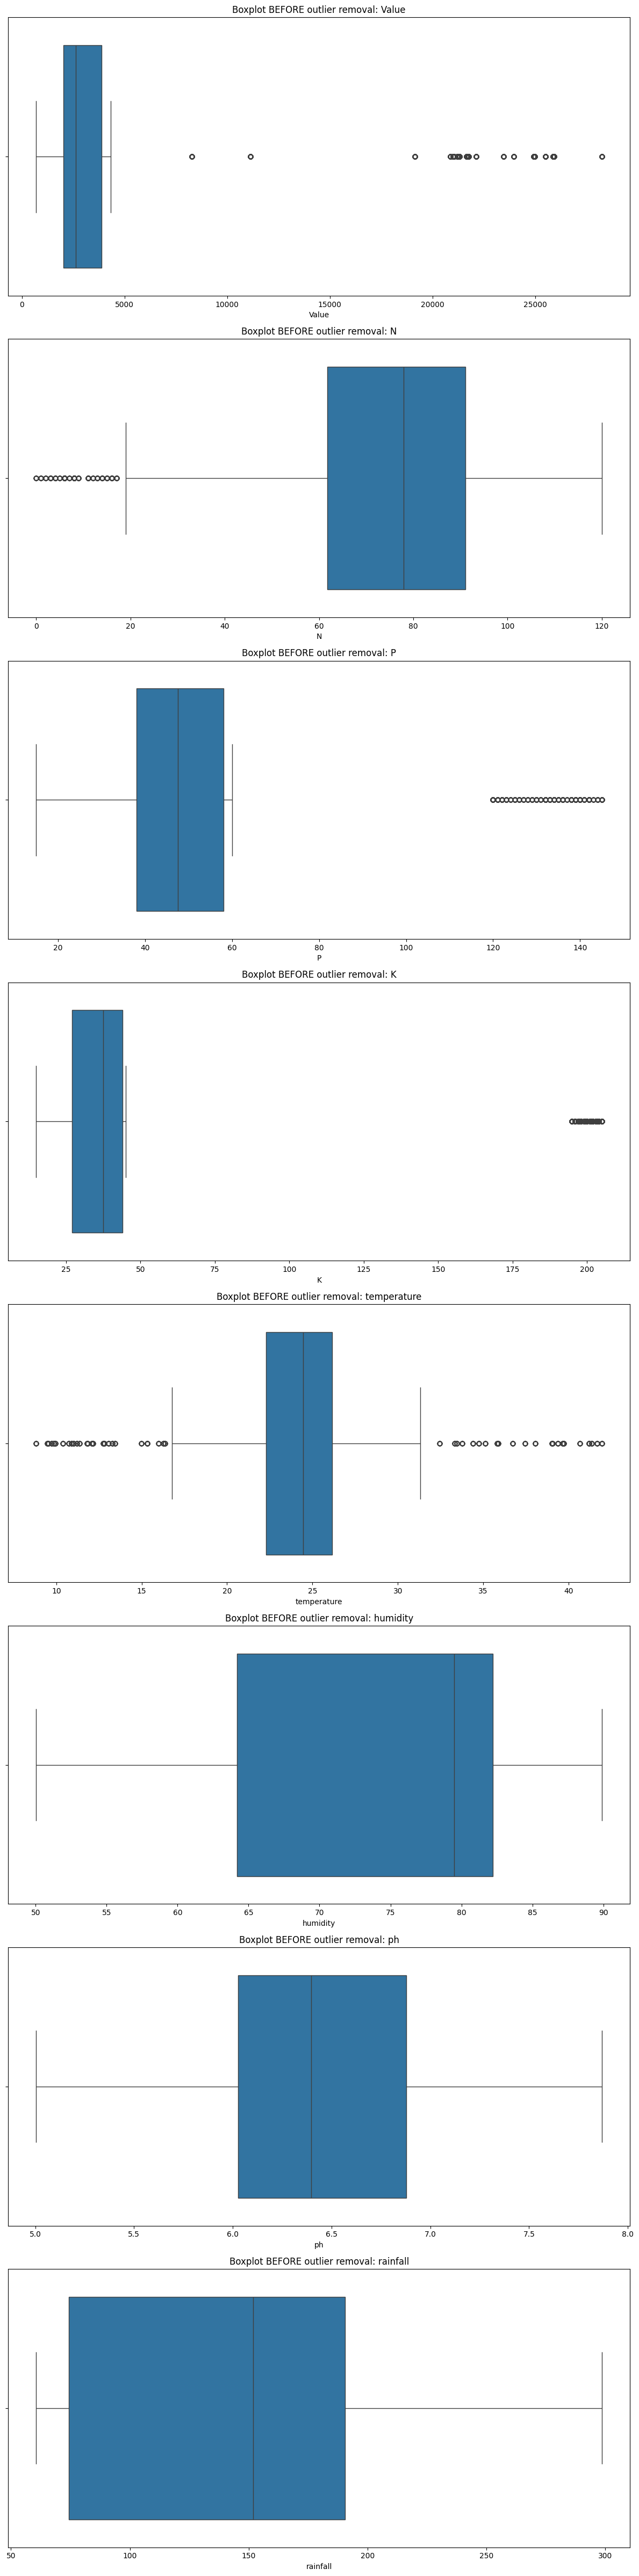

In [14]:
# Cell 11: Boxplots before outlier removal
import matplotlib.pyplot as plt
import seaborn as sns

# Choose numeric columns for boxplots (common in crop dataset)
numeric_cols = []
for c in ['Value','N','P','K','temperature','humidity','ph','rainfall']:
    # find case-insensitive in merged
    matches = [col for col in merged.columns if col.lower()==c.lower()]
    if matches:
        numeric_cols.append(matches[0])

print("Numeric columns used for boxplots:", numeric_cols)
if not numeric_cols:
    print("No expected numeric columns found in merged dataset. Numeric columns available:")
    display(merged.select_dtypes(include='number').columns.tolist())
else:
    plt.figure(figsize=(12, 6 * len(numeric_cols)))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols), 1, i)
        sns.boxplot(x=merged[col])
        plt.title(f"Boxplot BEFORE outlier removal: {col}")
    plt.tight_layout()
    plt.show()


In [15]:
# Cell 12: Remove nulls and duplicates and show shapes
print("Shape before dropna/drop_duplicates:", merged.shape)
merged_clean = merged.dropna().copy()
print("Shape after dropna:", merged_clean.shape)
merged_clean = merged_clean.drop_duplicates().copy()
print("Shape after drop_duplicates:", merged_clean.shape)

print("\nNull counts now:")
display(merged_clean.isnull().sum())


Shape before dropna/drop_duplicates: (12000, 16)
Shape after dropna: (12000, 16)
Shape after drop_duplicates: (12000, 16)

Null counts now:


,0
Area,0
Year,0
Unit,0
Value,0
Element,0
Area Code (M49),0
Item Code (CPC),0
crop_clean,0
N,0
P,0


In [16]:
# Cell 13: Remove outliers using IQR on the numeric_cols chosen earlier and show counts
import numpy as np

if not numeric_cols:
    print("No numeric cols for outlier removal. Skipping.")
else:
    df = merged_clean.copy()
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # boolean mask: True if NOT an outlier across any numeric column
    mask = ~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

    before = df.shape[0]
    df_iqr = df[mask].copy()
    after = df_iqr.shape[0]

    print(f"Rows before outlier removal: {before}")
    print(f"Rows after outlier removal:  {after}")
    print(f"Rows removed: {before-after} ({(before-after)/before*100:.2f}%)")

    merged_clean_iqr = df_iqr.copy()
    display(merged_clean_iqr.head())


Rows before outlier removal: 12000
Rows after outlier removal:  9600
Rows removed: 2400 (20.00%)


,Area,Year,Unit,Value,Element,Area Code (M49),Item Code (CPC),crop_clean,N,P,K,temperature,humidity,ph,rainfall,Crop
0,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,91,21,26,26.333780,57.364700,7.261314,191.654941,coffee
1,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,107,21,26,26.452885,55.322227,7.235070,144.686134,coffee
2,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,83,38,35,25.708227,52.886671,7.189156,136.732509,coffee
3,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,108,24,31,24.128325,56.181077,6.431900,147.275782,coffee
4,India,2000,kg/ha,946.7,Yield,356,1610.0,coffee,116,28,34,23.443723,60.395233,6.423211,122.210325,coffee


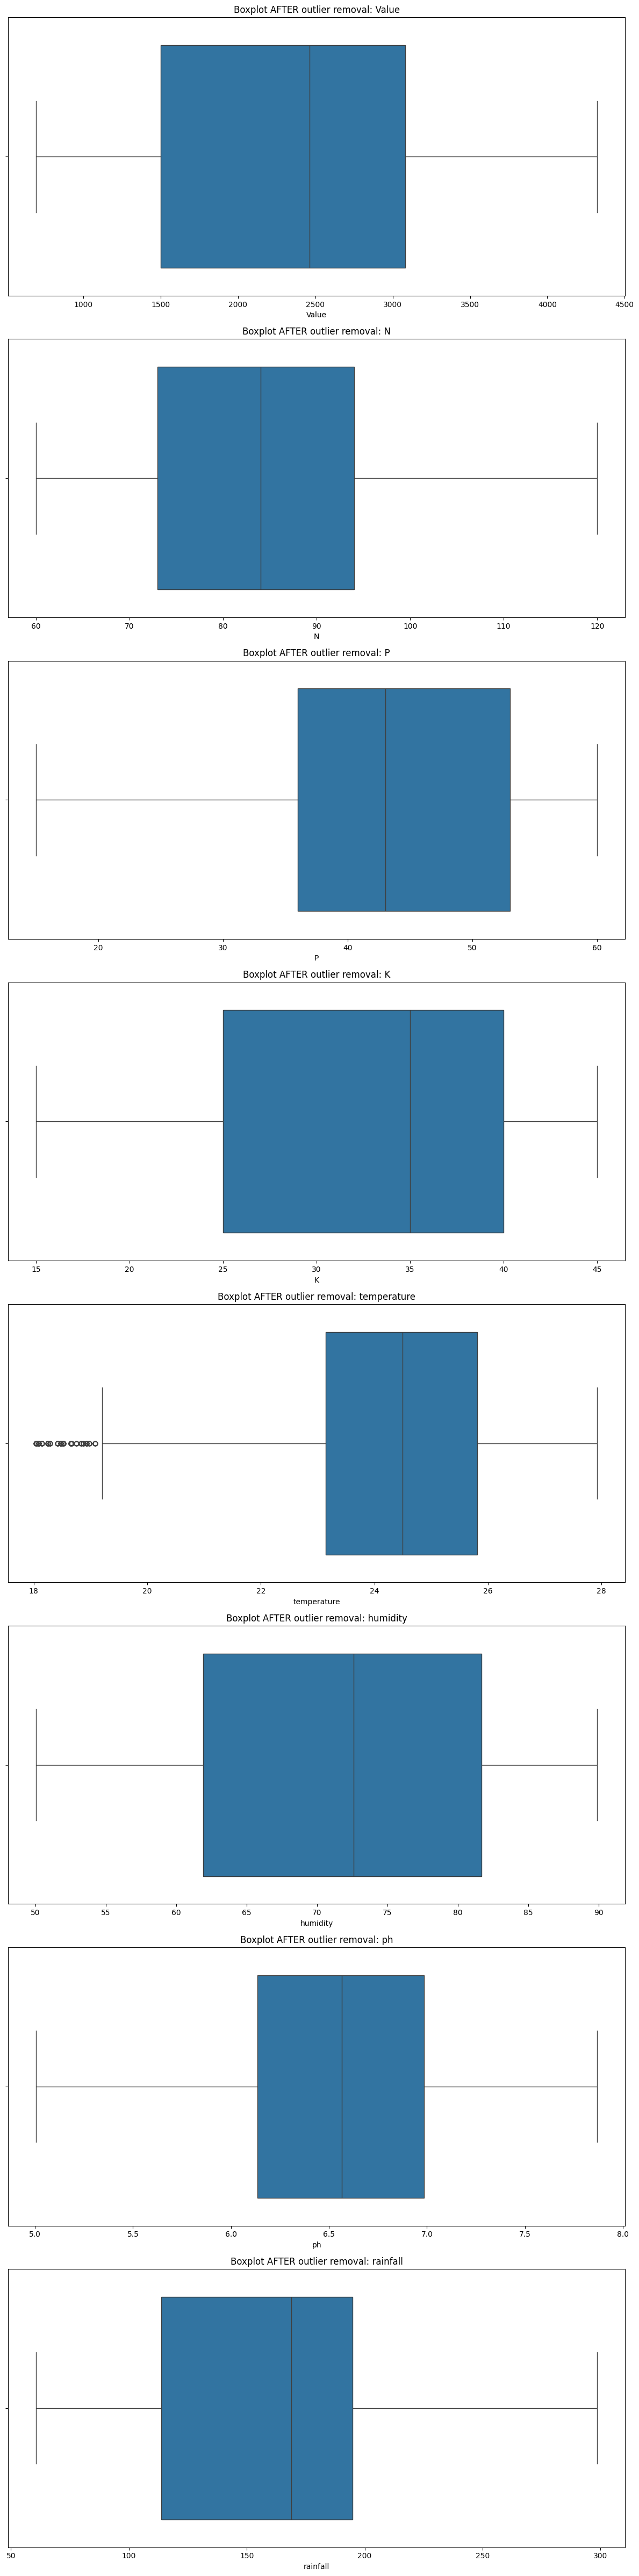

In [17]:
# Cell 14: Boxplots after outlier removal
if numeric_cols and 'merged_clean_iqr' in globals():
    plt.figure(figsize=(12, 6 * len(numeric_cols)))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols), 1, i)
        sns.boxplot(x=merged_clean_iqr[col])
        plt.title(f"Boxplot AFTER outlier removal: {col}")
    plt.tight_layout()
    plt.show()
else:
    print("No cleaned dataset available for boxplots after outlier removal.")


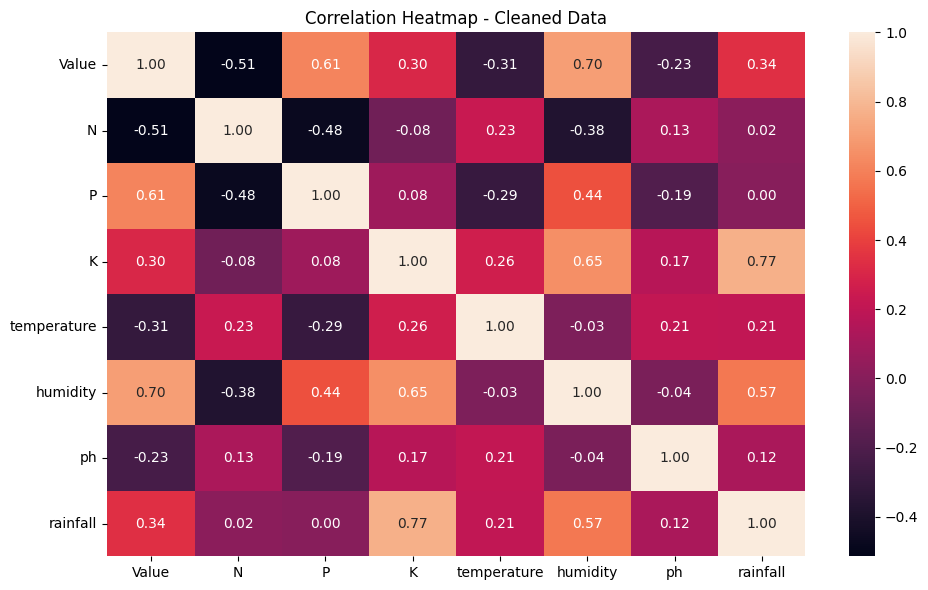

In [18]:
# Cell 15: Correlation heatmap and pairplot on cleaned data
if numeric_cols and 'merged_clean_iqr' in globals() and len(numeric_cols) > 1:
    plt.figure(figsize=(10,6))
    sns.heatmap(merged_clean_iqr[numeric_cols].corr(), annot=True, fmt=".2f")
    plt.title("Correlation Heatmap - Cleaned Data")
    plt.tight_layout()
    plt.show()




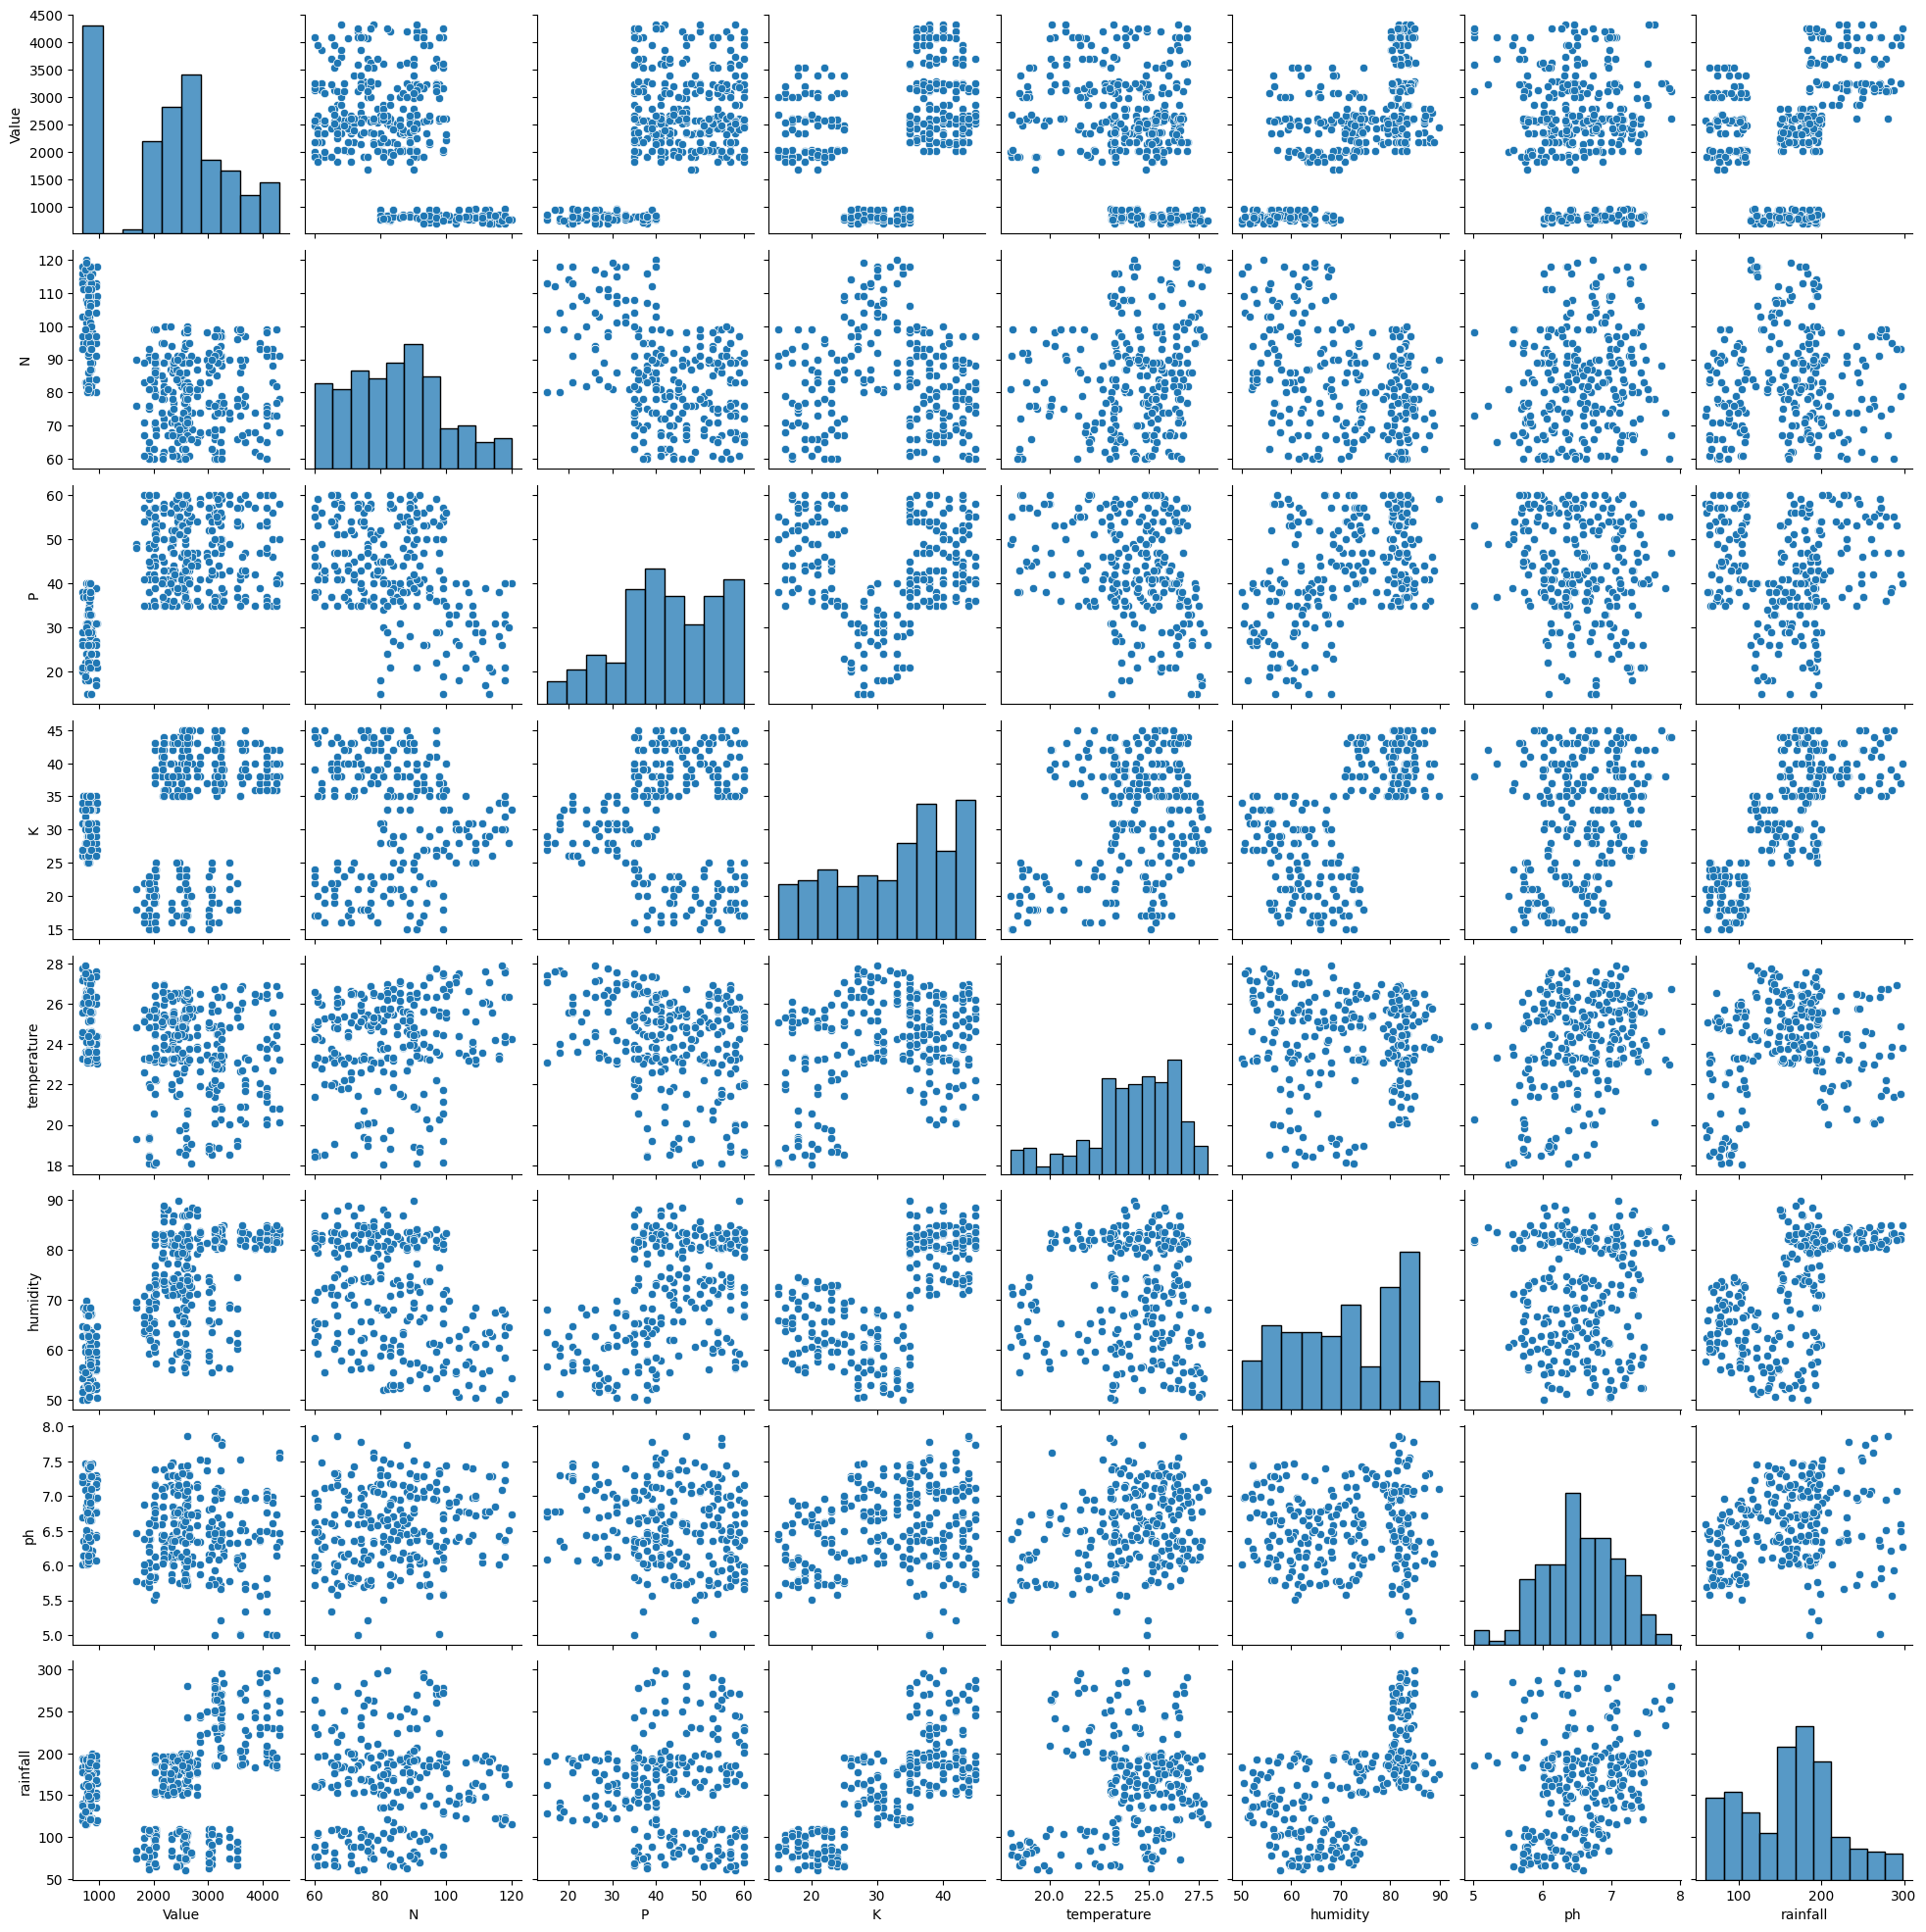

In [21]:
# Pairplot on a sample up to 400 rows
if numeric_cols and 'merged_clean_iqr' in globals() and len(numeric_cols) > 1:
    sample = merged_clean_iqr[numeric_cols].sample(n=min(400, merged_clean_iqr.shape[0]), random_state=42)
    sns.pairplot(sample)
    plt.show()
else:
    print("Not enough numeric data to plot heatmap/pairplot.")